In [1]:
from __future__ import print_function
from __future__ import division

from sys import version_info
if version_info[0]==2:
    range = xrange
    import cPickle as pickle # for storing and retrieving dictionaries
elif version_info[0]==3:
    import pickle # for storing and retrieving dictionaries

from math import exp, log
import os
import subprocess
import sys
import time
from glob import glob
from itertools import combinations
from itertools import product as combinations_product
from collections import defaultdict
from multiprocessing import Pool, cpu_count
from argparse import ArgumentParser
from difflib import SequenceMatcher
from operator import itemgetter
import zipfile

from Bio import SeqIO
from Bio.SeqFeature import BeforePosition, AfterPosition
from Bio import AlignIO
from Bio import pairwise2
from Bio.SubsMat.MatrixInfo import pam250 as scoring_matrix
from Bio import Phylo

from functions import *
from ArrowerSVG import *

import numpy as np
from array import array
from scipy.sparse import lil_matrix
from scipy.optimize import linear_sum_assignment
import json
import shutil
from distutils import dir_util
from sklearn.cluster import AffinityPropagation
from IPython.core.display import SVG as SVG_show

import pandas as pd
import re
import numpy as np
from functools import reduce
import copy
#from collection import defaultdict
import statistics
from pathlib import Path
from IPython.display import SVG as SVG_show
import svgutils.transform as sg
import sys 

global BGCDir
global antismashDir
global visualDir 
global valid_classes
global pfam_dir
global filter_dict_gcf , dict_all_gc

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" 

In [3]:
def listToString(s):  
    
    # initialize an empty string 
    str1 = ""  
    
    # traverse in the string   
    for ele in s:  
        str1 += ele   
    
    # return string   
    return str1  

In [4]:
def process_gbk_files(gbk, min_bgc_size, bgc_info, files_no_proteins, files_no_biosynthetic_genes,bgc_fasta_folder):
    """ Given a file path to a GenBank file, reads information about the BGC"""

    biosynthetic_genes = set()
    product_list_per_record = []
    fasta_data = []
    save_fasta = True
    adding_sequence = False
    contig_edge = False
    total_seq_length = 0
    record_end = 0
    offset_record_position = 0
    bgc_locus_tags = []
    locus_sequences = {}
    locus_coordinates = {}
    genbankDict = {}
    
    
    file_folder, fname = os.path.split(gbk)
    clusterName = fname[:-4]

    # See if we need to keep the sequence
    # (Currently) we have to open the file anyway to read all its 
    # properties for bgc_info anyway...
    outputfile = os.path.join(bgc_fasta_folder, clusterName + '.fasta')
    if os.path.isfile(outputfile) and os.path.getsize(outputfile) > 0:
        if verbose:
            print(" File {} already processed".format(outputfile))
        save_fasta = False
    else:
        save_fasta = True
    
    try:
        # basic file verification. Substitutes check_data_integrity
        records = list(SeqIO.parse(gbk, "genbank"))
    except ValueError as e:
        print("   Error with file {}: \n    '{}'".format(gbk, str(e)))
        print("    (This file will be excluded from the analysis)")
        return
    else:
        total_seq_length = 0
        bgc_size = 0
        cds_ctr = 0
        product = "no type"
        offset_record_position = 0
        
        max_width = 0 # This will be used for the SVG figure
        record_count = 0
        
        for record in records:
            record_count += 1
            bgc_size += len(record.seq)
            if len(record.seq) > max_width:
                max_width = len(record.seq)
            
            for feature in record.features:
                # antiSMASH <= 4
                if feature.type == "cluster":
                    if "product" in feature.qualifiers:
                        # in antiSMASH 4 there should only be 1 product qualifiers
                        for product in feature.qualifiers["product"]:
                            for p in product.replace(" ","").split("-"):
                                product_list_per_record.append(p)
                                
                    if "contig_edge" in feature.qualifiers:
                        # there might be mixed contig_edge annotations
                        # in multi-record files. Turn on contig_edge when
                        # there's at least one annotation
                        if feature.qualifiers["contig_edge"][0] == "True":
                            if verbose:
                                print(" Contig edge detected in {}".format(fname))
                            contig_edge = True
                        
                # antiSMASH = 5
                if "region" in feature.type:
                    if "product" in feature.qualifiers:
                        for product in feature.qualifiers["product"]:
                            product_list_per_record.append(product)
                            
                    if "contig_edge" in feature.qualifiers:
                        # there might be mixed contig_edge annotations
                        # in multi-record files. Turn on contig_edge when
                        # there's at least one annotation
                        if feature.qualifiers["contig_edge"][0] == "True":
                            if verbose:
                                print(" Contig edge detected in {}".format(fname))
                            contig_edge = True
                            
                        
                # Get biosynthetic genes + sequences
                if feature.type == "CDS":
                    cds_ctr += 1
                    CDS = feature
                    
                    gene_id = ""
                    if "gene" in CDS.qualifiers:
                        gene_id = CDS.qualifiers.get('gene',"")[0]
                        
                    
                    protein_id = ""
                    if "protein_id" in CDS.qualifiers:
                        protein_id = CDS.qualifiers.get('protein_id',"")[0]
                    
                    # nofuzzy_start/nofuzzy_end are obsolete
                    # http://biopython.org/DIST/docs/api/Bio.SeqFeature.FeatureLocation-class.html#nofuzzy_start
                    gene_start = offset_record_position + max(0, int(CDS.location.start))
                    gene_end = offset_record_position + max(0, int(CDS.location.end))
                    record_end = gene_end
                    
                    direction = CDS.location.strand
                    if direction == 1:
                        strand = '+'
                    else:
                        strand = '-'
                        
                    fasta_header = "{}_ORF{}:gid:{}:pid:{}:loc:{}:{}:strand:{}".format(clusterName, str(cds_ctr), str(gene_id).replace(":","_"), str(protein_id).replace(":","_"), str(gene_start), str(gene_end), strand)
                    fasta_header = fasta_header.replace(">","") #the coordinates might contain larger than signs, tools upstream don't like this
                    fasta_header = fasta_header.replace(" ", "") #the domtable output format (hmmscan) uses spaces as a delimiter, so these cannot be present in the fasta header

                    # antiSMASH <=4
                    if "sec_met" in feature.qualifiers:
                        if "Kind: biosynthetic" in feature.qualifiers["sec_met"]:
                            biosynthetic_genes.add(fasta_header)

                    # antiSMASH == 5
                    if "gene_kind" in feature.qualifiers:
                        if "biosynthetic" in feature.qualifiers["gene_kind"]:
                            biosynthetic_genes.add(fasta_header)
                    
                    fasta_header = ">"+fasta_header
                    

                    if 'translation' in CDS.qualifiers.keys():
                        prot_seq = CDS.qualifiers['translation'][0]
                    # If translation isn't available translate manually, this will take longer
                    else:
                        nt_seq = CDS.location.extract(record.seq)
                        
                        # If we know sequence is an ORF (like all CDSs), codon table can be
                        #  used to correctly translate alternative start codons.
                        #  see http://biopython.org/DIST/docs/tutorial/Tutorial.html#htoc25
                        # If the sequence has a fuzzy start/end, it might not be complete,
                        # (therefore it might not be the true start codon)
                        # However, in this case, if 'translation' not available, assume 
                        #  this is just a random sequence 
                        complete_cds = False 
                        
                        # More about fuzzy positions
                        # http://biopython.org/DIST/docs/tutorial/Tutorial.html#htoc39
                        fuzzy_start = False 
                        if str(CDS.location.start)[0] in "<>":
                            complete_cds = False
                            fuzzy_start = True
                            
                        fuzzy_end = False
                        if str(CDS.location.end)[0] in "<>":
                            fuzzy_end = True
                        
                        #for protein sequence if it is at the start of the entry assume 
                        # that end of sequence is in frame and trim from the beginning
                        #if it is at the end of the genbank entry assume that the start 
                        # of the sequence is in frame
                        reminder = len(nt_seq)%3
                        if reminder > 0:
                            if fuzzy_start and fuzzy_end:
                                print("Warning, CDS ({}, {}) has fuzzy\
                                    start and end positions, and a \
                                    sequence length not multiple of \
                                    three. Skipping".format(clusterName, 
                                    CDS.qualifiers.get('locus_tag',"")[0]))
                                break
                            
                            if fuzzy_start:
                                if reminder == 1:
                                    nt_seq = nt_seq[1:]
                                else:
                                    nt_seq = nt_seq[2:]
                            # fuzzy end
                            else:
                                #same logic reverse direction
                                if reminder == 1:
                                    nt_seq = nt_seq[:-1]
                                else:
                                    nt_seq = nt_seq[:-2]
                        
                        # The Genetic Codes: www.ncbi.nlm.nih.gov/Taxonomy/Utils/wprintgc.cgi
                        if "transl_table" in CDS.qualifiers.keys():
                            CDStable = CDS.qualifiers.get("transl_table", "")[0]
                            prot_seq = str(nt_seq.translate(table=CDStable, to_stop=True, cds=complete_cds))
                        else:
                            prot_seq = str(nt_seq.translate(to_stop=True, cds=complete_cds))
                            
                    total_seq_length += len(prot_seq)
                
                
                    bgc_locus_tags.append(fasta_header)
                    locus_sequences[fasta_header] = prot_seq
                    locus_coordinates[fasta_header] = (gene_start, gene_end, len(prot_seq))
                    

            # TODO: if len(biosynthetic_genes) == 0, traverse record again
            # and add CDS with genes that contain domains labeled sec_met
            # we'll probably have to have a list of domains if we allow
            # fasta files as input
            
            # make absolute positions for ORFs in next records
            offset_record_position += record_end + 100
        
        if bgc_size > min_bgc_size:  # exclude the bgc if it's too small
            # check what we have product-wise
            # In particular, handle different products for multi-record files
            product_set = set(product_list_per_record)
            if len(product_set) == 1: # only one type of product
                product = product_list_per_record[0]
            elif "other" in product_set: # more than one, and it contains "other"
                if len(product_set) == 2:
                    product = list(product_set - {'other'})[0] # product = not "other"
                else:
                    product = ".".join(product_set - {'other'}) # likely a hybrid
            else:
                product = ".".join(product_set) # likely a hybrid
                
            # Don't keep this bgc if its type not in valid classes specified by user
            # This will avoid redundant tasks like domain detection
            subproduct = set()
            for p in product.split("."):
                subproduct.add(sort_bgc(p).lower())
            if "nrps" in subproduct and ("pksi" in subproduct or "pksother" in subproduct):
                subproduct.add("pks-nrp_hybrids")
                
            if len(valid_classes & subproduct) == 0:
                if verbose:
                    print(" Skipping {} (type: {})".format(clusterName, product))
                return False
            
            # assuming that the definition field is the same in all records
            # product: antiSMASH predicted class of metabolite
            # gbk definition
            # number of records (for Arrower figures)
            # max_width: width of the largest record (for Arrower figures)
            # id: the GenBank's accession
            #bgc_info[clusterName] = (product, records[0].description, len(records), max_width, records[0].id, biosynthetic_genes.copy())
            # TODO contig_edge annotation is not present for antiSMASH v < 4
            # Perhaps we can try to infer if it's in a contig edge: if
            # - first biosynthetic gene start < 10kb or
            # - max_width - last biosynthetic gene end < 10kb (but this will work only for the largest record)
            bgc_info[clusterName] = bgc_data(records[0].id, records[0].description, product, len(records), max_width, 
                                             bgc_size + (record_count-1)*1000, records[0].annotations["organism"], 
                                             ",".join(records[0].annotations["taxonomy"]), biosynthetic_genes.copy(), 
                                             contig_edge)

            if len(bgc_info[clusterName].biosynthetic_genes) == 0:
                files_no_biosynthetic_genes.append(clusterName+".gbk")

            # TODO why re-process everything if it was already in the list?
            # if name already in genbankDict.keys -> add file_folder
            # else: extract all info
            if clusterName in genbankDict.keys():
                # Name was already in use. Use file_folder as the new sample's name
                genbankDict[clusterName][1].add(file_folder) 
            else:
                # See if we need to write down the sequence
                if total_seq_length > 0:
                    # location of first instance of the file is genbankDict[clustername][0]
                    genbankDict.setdefault(clusterName, [gbk, set([file_folder])])

                    if save_fasta:
                        # Find overlaps in CDS regions and delete the shortest ones.
                        # This is thought as a solution for selecting genes with 
                        # alternate splicing events
                        # Food for thought: imagine CDS A overlapping CDS B overlapping
                        # CDS C. If len(A) > len(B) > len(C) and we first compare A vs B
                        # and delete A, then B vs C and delete B: would that be a better
                        # solution than removing B? Could this actually happen?
                        # TODO What if the overlapping CDS is in the reverse strand?
                        #  maybe it should be kept as it is
                        # TODO what are the characterized differences in prokarytote
                        #  vs eukaryote CDS overlap?
                        del_list = set()
                        for a, b in combinations(bgc_locus_tags, 2):
                            a_start, a_end, a_len = locus_coordinates[a]
                            b_start, b_end, b_len = locus_coordinates[b]
                            
                            if b_end <= a_start or b_start >= a_end:
                                pass
                            else:
                                # calculate overlap
                                if a_start > b_start:
                                    ov_start = a_start
                                else:
                                    ov_start = b_start

                                if a_end < b_end:
                                    ov_end = a_end
                                else:
                                    ov_end = b_end

                                overlap_length = ov_end - ov_start
                                
                                # allow the overlap to be as large as 10% of the
                                # shortest CDS. Overlap length is in nucleotides
                                # here, whereas a_len, b_len are protein 
                                # sequence lengths
                                if overlap_length/3 > 0.1*min(a_len,b_len):
                                    if a_len > b_len:
                                        del_list.add(b)
                                    else:
                                        del_list.add(a)
                        
                        for locus in del_list:
                            if verbose:
                                print("   Removing {} because it overlaps with other ORF".format(locus))
                            bgc_locus_tags.remove(locus)
                        
                        with open(outputfile,'w') as fastaHandle:
                            for locus in bgc_locus_tags:
                                fastaHandle.write("{}\n".format(locus))
                                fastaHandle.write("{}\n".format(locus_sequences[locus]))
                            adding_sequence = True
                else:
                    files_no_proteins.append(fname)

            if verbose:
                print("  Adding {} ({} bps)".format(fname, str(bgc_size)))
                                
        else:
            print(" Discarding {} (size less than {} bp, was {})".format(clusterName, str(min_bgc_size), str(bgc_size)))
    
    return (adding_sequence, genbankDict)


In [5]:
def get_gbk_files(inputpath, outputdir, bgc_fasta_folder, min_bgc_size, include_gbk_str, exclude_gbk_str, bgc_info):
    """Searches given directory for genbank files recursively, will assume that
    the genbank files that have the same name are the same genbank file. 
    Returns a dictionary that contains the names of the clusters found as keys
    and a list that contains [0] a path to the genbank file and [1] the 
    samples that the genbank file is a part of.
    Extract and write the sequences as fasta files if not already in the Fasta 
    folder.
    return: {cluster_name:[genbank_path,[s_a,s_b...]]}
    """
    file_counter = 0
    processed_sequences = 0
    files_no_proteins = []
    files_no_biosynthetic_genes = []
    genbankDict = {}

    if os.path.isfile(inputpath):
        files = [inputpath]
    else:
        # Unfortunately, this does not work in Python 2:
        #files = glob(os.path.join(inputpath,"**/*.gbk"), recursive=True) 
        files = [os.path.join(dirpath, f) for dirpath, dirnames, files in os.walk(inputpath)
                 for f in files if f.endswith(".gbk")]
        
    for filepath in files:
        file_folder, fname = os.path.split(filepath)
        
        if len(include_gbk_str) == 1 and include_gbk_str[0] == "*":
            pass
        else:
            if not any([word in fname for word in include_gbk_str]):
                continue
            
            if exclude_gbk_str != [] and any([word in fname for word in exclude_gbk_str]):
                print(" Skipping file " + fname)
                continue
        
        if "_ORF" in fname:
            print(" Skipping file {} (string '_ORF' is used internally)".format(fname))
            continue
        
        if " " in filepath:
            sys.exit("\nError: Input GenBank files should not have spaces in their path as hmmscan cannot process them properly ('too many arguments').")
        
        file_counter += 1
        results =process_gbk_files(filepath, min_bgc_size, bgc_info, files_no_proteins, files_no_biosynthetic_genes,bgc_fasta_folder)
        if results[0]:
            processed_sequences += 1
            genbankDict.update(results[1])
    
    if len(files_no_proteins) > 0:
        print("  Warning: Input set has files without protein sequences. They will be discarded")
        print("   (See no_sequences_list.txt)")
        with open(os.path.join(outputdir, "no_sequences_list.txt"), "w") as noseqs:
            for f in sorted(files_no_proteins):
                noseqs.write("{}\n".format(f))
        
    if len(files_no_biosynthetic_genes) > 0:
        print("  Warning: Input set has files with no Biosynthetic Genes (affects alignment mode)")
        print("   See no_biosynthetic_genes_list.txt")
        with open(os.path.join(outputdir, "logs", "no_biosynthetic_genes_list.txt"), "w") as nobiogenes:
            for f in sorted(files_no_biosynthetic_genes):
                nobiogenes.write("{}\n".format(f))
    
    print("\n Starting with {:d} files".format(file_counter))
    print(" Files that had its sequence extracted: {:d}".format(processed_sequences))
    
    return (genbankDict)

In [6]:
os.chdir("/home/mlk442/FIND/mlk442/gcf_visulization")
visualDir ="/home/mlk442/FIND/mlk442/gcf_visulization"
BGCDir = "/home/mlk442/FIND/mlk442/BGC_table"
antismashDir = "/home/mlk442/FIND/MicroMGx_Pilot/genomics/antismash_outputs"
# Read tables
gcfsData = pd.read_table("gcfs_data.txt", sep = "\t")
dict_gcf = dict(zip(gcfsData.gcf.tolist(), gcfsData.bgcs.tolist()))
gcfsNames = dict_gcf.keys()

In [7]:
bgc_class_weight = {}
bgc_class_weight["PKSI"] = (0.22, 0.76, 0.02, 1.0)
bgc_class_weight["PKSother"] = (0.0, 0.32, 0.68, 4.0)
bgc_class_weight["NRPS"] = (0.0, 1.0, 0.0, 4.0)
bgc_class_weight["RiPPs"] = (0.28, 0.71, 0.01, 1.0)
bgc_class_weight["Saccharides"] = (0.0, 0.0, 1.0, 1.0)
bgc_class_weight["Terpene"] = (0.2, 0.75, 0.05, 2.0)
bgc_class_weight["PKS-NRP_Hybrids"] = (0.0, 0.78, 0.22, 1.0)
bgc_class_weight["Others"] = (0.01, 0.97, 0.02, 4.0)
    
#define which classes will be analyzed (if in the options_classify mode)
valid_classes = set()
for key in bgc_class_weight:
    valid_classes.add(key.lower())

In [8]:
pfam_dir = "/home/mlk442/FIND/mlk442/software"
h3f = os.path.join(pfam_dir, "Pfam-A.hmm.h3f")
h3i = os.path.join(pfam_dir, "Pfam-A.hmm.h3i")
h3m = os.path.join(pfam_dir, "Pfam-A.hmm.h3m")
h3p = os.path.join(pfam_dir, "Pfam-A.hmm.h3p")

In [9]:
#filter the unrelated gene clusters in each gene cluster family
filter_dict_gcf = dict()
for k in gcfsNames:
    filteredValue = list(filter(lambda x: re.match("DA|DB", x) != None,
                                    dict_gcf[k].split()))
    if len(filteredValue) >0:
        filter_dict_gcf[k] = filteredValue

In [10]:
class bgc_data:
        def __init__(self, accession_id, description, product, records, max_width, bgc_size, organism, taxonomy, biosynthetic_genes, contig_edge):
            # These two properties come from the genbank file:
            self.accession_id = accession_id
            self.description = description
            # AntiSMASH predicted class of compound:
            self.product = product
            # number of records in the genbank file (think of multi-locus BGCs):
            self.records = records
            # length of largest record (it will be used for ArrowerSVG):
            self.max_width = int(max_width)
            # length of the entire bgc (can include several records/subclusters)
            self.bgc_size = bgc_size
            # organism
            self.organism = organism
            # taxonomy as a string (of comma-separated values)
            self.taxonomy = taxonomy
            # Internal set of tags corresponding to genes that AntiSMASH marked 
            # as "Kind: Biosynthetic". It is formed as
            # clusterName + "_ORF" + cds_number + ":gid:" + gene_id + ":pid:" + protein_id + ":loc:" + gene_start + ":" + gene_end + ":strand:" + {+,-}
            self.biosynthetic_genes = biosynthetic_genes
            # AntiSMASH 4+ marks BGCs that sit on the edge of a contig
            self.contig_edge = contig_edge

In [11]:
def getGbkPath(gcf):
    '''Function to get gbk path for a gcf. '''
    gbkPath = []
    dict_gbk_gc = {}
    for i in gcf:
        strain = i.split("_")[0]
        bgc = BGCDir +"/"+ strain +"_BGC_table.csv"
        if Path(bgc).is_file():
            bgcTable =  pd.read_csv(bgc, header = 1)
            gbkPath.append(os.path.join(antismashDir,listToString(bgcTable[bgcTable["ID"] == i]["GenBank"].tolist())))
            dict_gbk_gc[i] = listToString(bgcTable[bgcTable["ID"] == i]["GenBank"].tolist()).split("/")[1]
    return (gbkPath, dict_gbk_gc)

In [12]:
def launch_hmmalign(cores, domain_sequence_list):
    """
    Launches instances of hmmalign with multiprocessing.
    Note that the domains parameter contains the .fasta extension
    """
    pool = Pool(cores, maxtasksperchild=32)
    pool.map(run_hmmalign, domain_sequence_list)
    pool.close()
    pool.join()

In [13]:
def run_hmmalign(domain_file):
    #domain_file already contains the full path, with the file extension
    domain_base = domain_file.split(os.sep)[-1][:-6]
    hmmfetch_pars = ["hmmfetch", os.path.join(pfam_dir,"Pfam-A.hmm.h3m"), domain_base]
    proc_hmmfetch = subprocess.Popen(hmmfetch_pars, stdout=subprocess.PIPE, shell=False)
    
    domain_file_stk = domain_file[:-6]+".stk"
    hmmalign_pars = ["hmmalign", "-o", domain_file_stk, "-", domain_file]
    proc_hmmalign = subprocess.Popen(hmmalign_pars, stdin=proc_hmmfetch.stdout, stdout=subprocess.PIPE, shell=False)
    
    proc_hmmfetch.stdout.close()
    proc_hmmalign.communicate()[0]
    proc_hmmfetch.wait()
    
    if verbose:
        print(" ".join(hmmfetch_pars) + " | " + " ".join(hmmalign_pars))
    
    stockholm_parser(domain_file_stk)

In [14]:
def runHmmScan(fastaPath, hmmPath, outputdir, verbose):
    """ Runs hmmscan command on a fasta file with a single core to generate a
    domtable file"""
    hmmFile = os.path.join(hmmPath,"Pfam-A.hmm")
    if os.path.isfile(fastaPath):
        name = ".".join(fastaPath.split(os.sep)[-1].split(".")[:-1])
        outputName = os.path.join(outputdir, name+".domtable")
        
        hmmscan_cmd = "hmmscan --cpu 0 --domtblout {} --cut_tc {} {}".format(outputName, hmmFile, fastaPath)
        if verbose == True:
            print("   " + hmmscan_cmd)
        subprocess.check_output(hmmscan_cmd, shell=True)

    else:
        sys.exit("Error running hmmscan: Fasta file " + fastaPath + " doesn't exist")

In [15]:
def parseHmmScan(hmmscanResults, pfd_folder, pfs_folder, overlapCutoff, genbankDict):
    outputbase = ".".join(hmmscanResults.split(os.sep)[-1].split(".")[:-1])
    # try to read the domtable file to find out if this gbk has domains. Domains
    # need to be parsed into fastas anyway.
    if os.path.isfile(hmmscanResults):
        pfd_matrix = domtable_parser(outputbase, hmmscanResults)
        
        # get number of domains to decide if this BGC should be removed
        num_domains = len(pfd_matrix)

        if num_domains > 0:
            if verbose:
                print("  Processing domtable file: " + outputbase)

            # check_overlap also sorts the filtered_matrix results and removes
            # overlapping domains, keeping the highest scoring one
            filtered_matrix, domains = check_overlap(pfd_matrix,overlapCutoff)
            
            # Save list of domains per BGC
            pfsoutput = os.path.join(pfs_folder, outputbase + ".pfs")
            with open(pfsoutput, 'w') as pfs_handle:
                pfs_handle.write(" ".join(domains))
            
            # Save more complete information of each domain per BGC
            pfdoutput = os.path.join(pfd_folder, outputbase + ".pfd")
            with open(pfdoutput,'w') as pfd_handle:
                write_pfd(pfd_handle, filtered_matrix)
        else:
            # there aren't any domains in this BGC
            # delete from all data structures
            print("  No domains where found in {}.domtable. Removing it from further analysis".format(outputbase))
            info = genbankDict.get(outputbase)
            #clusters.remove(outputbase) pan modified
            baseNames.remove(outputbase)
            gbk_files.remove(info[0])
            for sample in info[1]:
                sampleDict[sample].remove(outputbase)
            del genbankDict[outputbase]
            if outputbase in mibig_set:
                mibig_set.remove(outputbase)
            
    else:
        sys.exit("Error: hmmscan file " + outputbase + " was not found! (parseHmmScan)")

    return("")

In [16]:
def create_pfam_dict(pfs_folder):
    pfs_paths = os.listdir(pfs_folder)
    PFs =[]
    pfam_text = {} 
    for pfsname in pfs_paths:
        pfspath = os.path.join(pfs_folder,pfsname )
        y = pd.read_table(pfspath, sep = "\s+")
        PFs = PFs + y.columns.values.tolist()
    new_PFs = []
    j = 0
    for i in PFs:
        pf = re.split("\.", i)[0]
        if pf not in new_PFs:
            new_PFs.append(pf)
            pfam_text[pf]=str(j+1) 
            j = j+1   
    return pfam_text
#create_pfam_dict('/home/mlk442/FIND/mlk442/gcf_visulization/NRPS_263/cache/pfs')

In [17]:
def addInfoGBK(origGBK, newGBK):
    record1 = SeqIO.read(origGBK, "genbank")
    record2 = SeqIO.read(newGBK, "genbank")
    for feature1 in record1.features:
        if (feature1.type == "CDS") and (feature2.type == 'CDS') and (feature1.location == feature2.location):
            if "gene" in feature2.qualifiers.keys():
                feature1.qualifiers['gene'] = feature2.qualifiers['gene']
            if "product" in feature2.qualifiers.keys():
                feature1.qualifiers['product'] = feature2.qualifiers['product']                        
    with open("newGBK", "w") as handle:
        SeqIO.write(record1, handle, "genbank")    
    

In [18]:
def run_visual(gcfName, filter_dict_gcf, visualDir):
    '''Function to transform antismash gbk to annotated gbk, then generate SVG, domtable, pfd, pfs, fasta.
    '''
    output_folder = os.path.join(visualDir, gcfName)
    input_folder = os.path.join(output_folder, "GBKfile")
    gbk_folder = os.path.join(output_folder, "origGBK")
    cache_folder = os.path.join(output_folder, "cache")
    svg_folder = os.path.join(output_folder, "SVG")    
    bgc_fasta_folder = os.path.join(cache_folder, "fasta")
    domtable_folder = os.path.join(cache_folder, "domtable")
    pfs_folder = os.path.join(cache_folder, "pfs")
    pfd_folder = os.path.join(cache_folder, "pfd")
    domains_folder = os.path.join(cache_folder, "domains")
    create_directory(output_folder, "output", False)
    create_directory(input_folder, "input", False)
    create_directory(gbk_folder, "GBK", False)
    create_directory(cache_folder, "Cache", False)
    create_directory(bgc_fasta_folder, "BGCfastas", False)
    create_directory(domtable_folder, "Domtable", False)
    create_directory(domains_folder, "Domains", False)
    create_directory(pfs_folder, "pfs", False)
    create_directory(pfd_folder, "pfd", False)
    create_directory(svg_folder, "SVG", False)
    log_folder = os.path.join(output_folder, "logs")
    create_directory(log_folder, "Logs", False)

    bgc_info = {}
    gcs = filter_dict_gcf[gcfName]
    input_path, dict_gbk_gc = getGbkPath(gcs)
    for gbk in input_path:
        fastaName = re.split('/', gbk)[-1].replace('gbk', 'fasta')
        pre = re.split('/', gbk)[-1].replace('.gbk', '')
        fastaPath = os.path.join(input_folder, re.split('/', gbk)[-1].replace('gbk', 'fasta'))
        fasta_cmd = "seqret -sequence {} -outseq {} -osformat fasta".format(gbk, fastaPath )
        copy_cmd = "cp {} {}".format(gbk, gbk_folder)
        subprocess.check_output(copy_cmd, shell=True)
        subprocess.check_output(fasta_cmd, shell=True)
        gbk_cmd = "prokka --kingdom Bacteria --gcode 11 --cpus 8 --force --outdir {} --prefix {} {}".format(input_folder, pre, fastaPath)
        subprocess.check_output(gbk_cmd, shell=True)
    
    genbankDict = get_gbk_files(input_folder, output_folder, bgc_fasta_folder, 0, ['cluster', 'region'], ['final'], bgc_info)
    
    allFastaFiles = set(glob(os.path.join(bgc_fasta_folder,"*.fasta")))
    cores = cpu_count()
    baseNames = set(genbankDict.keys())
    pool = Pool(cores,maxtasksperchild=1)
    for fastaFile in allFastaFiles:
        print(fastaFile)
        print(verbose)
        pool.apply_async(runHmmScan,args=(fastaFile, pfam_dir, domtable_folder, verbose))
    pool.close()
    pool.join()    
    print(" Finished generating domtable files.")
    
    domtableFiles = set(glob(os.path.join(domtable_folder,"*.domtable")))
    for domtableFile in domtableFiles:
        parseHmmScan(domtableFile, pfd_folder, pfs_folder, 0.1, genbankDict)

    print(" Finished generating pfs and pfd files.")
    print("  Parsing hmm file for domain information")
    pfs_paths = os.listdir(pfs_folder)

    
    pfam_info = {}
    with open(os.path.join(pfam_dir, "Pfam-A.hmm"), "r") as pfam:
        putindict = False
    # assuming that the order of the information never changes
        for line in pfam:
            if line[:4] == "NAME":
                name = line.strip()[6:]
            if line[:3] == "ACC":
                acc = line.strip()[6:].split(".")[0]
            if line[:4] == "DESC":
                desc = line.strip()[6:]
                putindict = True
                
            if putindict:
                putindict = False
                desc = desc.replace('&', '&amp;')
                desc = desc.replace('>', '&lt;')
                desc = desc.replace('<', '&gt;')
                pfam_info[acc] = (name, desc)
    print("    Done")
    
    pfam_text = create_pfam_dict(pfs_folder)
    
    working_set = baseNames
    if len(working_set) > 0:
        color_genes = {}
        color_domains = read_color_domains_file()
        pfam_domain_categories = {}
        
        #This must be done serially, because if a color for a gene/domain
        # is not found, the text files with colors need to be updated
        print("  Reading BGC information and writing SVG")
        for bgc in working_set:
            with open(genbankDict[bgc][0],"r") as handle:
                #print (bgc_info[bgc].records)
                SVG(False, os.path.join(svg_folder,bgc+".svg"), handle, bgc, os.path.join(pfd_folder,bgc+".pfd"), True, color_genes, color_domains, pfam_domain_categories, pfam_info, bgc_info[bgc].records, bgc_info[bgc].max_width,pfam_text)
        
        color_genes.clear()
        color_domains.clear()
        pfam_domain_categories.clear()
    elif len(working_set) == 0:
        print("All SVG from the input files seem to be in the SVG folder")
    
    return (genbankDict,dict_gbk_gc,pfam_info,pfam_text )

In [19]:
def generate_pfTable(PFs, pfam_info, pfam_text):
    '''Function to generate pfam table.'''
    out_list =[]
    for i in range(len(PFs)):
        new_PFs = re.split("\.",PFs[i])[0]
        if (new_PFs in pfam_info.keys()):
            pf_info = [pfam_text[new_PFs], new_PFs, pfam_info[new_PFs][0], pfam_info[new_PFs][1]]
            out_list.append(pf_info)
    pf_table = pd.DataFrame()
    pf_table = pf_table.append(out_list)
    pf_table.columns=["Number", "PF_id","PF_name","description"]
    pf_table = pf_table.drop_duplicates()
    pf_table = pf_table.reset_index(drop=True)
    return (pf_table)

In [20]:
def get_key (dict, value):
    return [k for k, v in dict.items() if v == value]

def cal_width(svgPaths, dict_gbk_gc, dict_propotion):
    widths = []
    dict_gbk2gc = dict(zip(dict_gbk_gc.values(), dict_gbk_gc.keys())) 
    for svgPath in svgPaths:
        file_folder, fname = os.path.split(svgPath)
        fname = fname.replace('svg', 'gbk')
        prop = abs(dict_propotion[dict_gbk2gc[fname]])
        wid = float(sg.fromfile(svgPath).get_size()[0])*(1+prop)
        widths.append(wid)
    max_wid = str(max(widths))
    return(max_wid)

def cat_svg(svg_paths, dict_gbk_gc, dict_propotion,dict_shifts,dict_total):
    n_svg = len(svg_paths)
    fig = sg.SVGFigure(cal_width(svg_paths,dict_gbk_gc,dict_propotion), str(100 *n_svg))
    figFile = []
    plot = []
    txt = []
    for i in range(n_svg):
        label = listToString(get_key(dict_gbk_gc, os.path.split(svg_paths[i])[1].replace('svg', 'gbk')))
        figFile.append(sg.fromfile(svg_paths[i]))
        plot.append(figFile[i].getroot())
        width = float(figFile[i].get_size()[0])
        if min(list(dict_shifts.values()))<0:
            if dict_propotion[label] == 0:
                x_ref = abs(min(list(dict_shifts.values())))/dict_total[label]*width
                plot[i].moveto(x_ref, 20+100*i, scale=1)
            if dict_propotion[label] != 0:
                x = x_ref + dict_shifts[label]/dict_total[label]*width
                plot[i].moveto(x, 20+100*i, scale=1)
        if min(list(dict_shifts.values())) == 0:
            if dict_propotion[label] == 0:
                plot[i].moveto(0, 20+100*i, scale=1)
            else:
                x = dict_propotion[label]*width
                plot[i].moveto(x, 20+100*i, scale=1)
        txt.append(sg.TextElement(0, 10 + 100*i, label, size=12, weight="bold"))
    fig.append(plot)
    fig.append(txt)
    finalSVG = os.path.join(os.path.split(svg_paths[0])[0],"fig_final.svg" )
    fig.save(finalSVG)
    return (finalSVG)    
    

In [21]:
#run gsf "NRPS_263" as an example
processed_gbk, dict_gbk_gc, pfam_info, pfam_text = run_visual("NRPS_263", filter_dict_gcf, visualDir)

 output folder already exists
 input folder already exists
 GBK folder already exists
 Cache folder already exists
 BGCfastas folder already exists
 Domtable folder already exists
 Domains folder already exists
 pfs folder already exists
 pfd folder already exists
 SVG folder already exists
 Logs folder already exists
   See no_biosynthetic_genes_list.txt

 Starting with 4 files
 Files that had its sequence extracted: 0
/home/mlk442/FIND/mlk442/gcf_visulization/NRPS_263/cache/fasta/c00026_NODE_26...region001.fasta
False
/home/mlk442/FIND/mlk442/gcf_visulization/NRPS_263/cache/fasta/c00058_NODE_58...region001.fasta
False
/home/mlk442/FIND/mlk442/gcf_visulization/NRPS_263/cache/fasta/c00004_NODE_4_...region002.fasta
False
/home/mlk442/FIND/mlk442/gcf_visulization/NRPS_263/cache/fasta/c00045_NODE_45...region001.fasta
False
 Finished generating domtable files.
 Finished generating pfs and pfd files.
  Parsing hmm file for domain information
    Done
All SVG from the input files seem to be 

In [22]:
gcs = filter_dict_gcf['NRPS_263']
input_path, dict_gbk_gc = getGbkPath(gcs)
dict_gbk_gc
input_path

{'DA976Z3332_32': 'c00058_NODE_58...region001.gbk',
 'DA575A0001_17': 'c00004_NODE_4_...region002.gbk',
 'DA918Z7165_25': 'c00045_NODE_45...region001.gbk',
 'DA976Z0895_10': 'c00026_NODE_26...region001.gbk'}

['/home/mlk442/FIND/MicroMGx_Pilot/genomics/antismash_outputs/DA976Z3332/c00058_NODE_58...region001.gbk',
 '/home/mlk442/FIND/MicroMGx_Pilot/genomics/antismash_outputs/DA575A0001/c00004_NODE_4_...region002.gbk',
 '/home/mlk442/FIND/MicroMGx_Pilot/genomics/antismash_outputs/DA918Z7165/c00045_NODE_45...region001.gbk',
 '/home/mlk442/FIND/MicroMGx_Pilot/genomics/antismash_outputs/DA976Z0895/c00026_NODE_26...region001.gbk']

In [23]:
#Output from run_visual
processed_gbk
#The GC name (DA976Z3332_32) is for SVG text purpose
dict_gbk_gc
# The pfam_info is for pfam table purpose
pfam_info['PF01314']

pfam_text

{}

{'DA976Z3332_32': 'c00058_NODE_58...region001.gbk',
 'DA575A0001_17': 'c00004_NODE_4_...region002.gbk',
 'DA918Z7165_25': 'c00045_NODE_45...region001.gbk',
 'DA976Z0895_10': 'c00026_NODE_26...region001.gbk'}

('AFOR_C', 'Aldehyde ferredoxin oxidoreductase, domains 2 &amp; 3')

{'PF00483': '1',
 'PF17912': '2',
 'PF00005': '3',
 'PF01451': '4',
 'PF01758': '5',
 'PF01022': '6',
 'PF00903': '7',
 'PF04237': '8',
 'PF00126': '9',
 'PF00975': '10',
 'PF09339': '11',
 'PF01614': '12',
 'PF00486': '13',
 'PF03704': '14',
 'PF00550': '15',
 'PF00109': '16',
 'PF02801': '17',
 'PF12697': '18',
 'PF07977': '19',
 'PF13561': '20',
 'PF01323': '21',
 'PF03621': '22',
 'PF03109': '23',
 'PF01636': '24',
 'PF01842': '25',
 'PF02153': '26',
 'PF00155': '27',
 'PF01070': '28',
 'PF14696': '29',
 'PF00067': '30',
 'PF13732': '31',
 'PF01061': '32',
 'PF04149': '33',
 'PF01135': '34',
 'PF13471': '35',
 'PF05402': '36',
 'PF00733': '37',
 'PF00296': '38',
 'PF01266': '39',
 'PF13581': '40',
 'PF00534': '41',
 'PF02826': '42',
 'PF04055': '43',
 'PF06463': '44',
 'PF02543': '45',
 'PF16861': '46',
 'PF13328': '47',
 'PF13439': '48',
 'PF00749': '49',
 'PF08032': '50',
 'PF00588': '51',
 'PF07681': '52',
 'PF02559': '53',
 'PF01128': '54',
 'PF02542': '55',
 'PF01406': '56',
 

In [24]:
dict_all_gc = dict_gbk_gc
dict_all_gc

{'DA976Z3332_32': 'c00058_NODE_58...region001.gbk',
 'DA575A0001_17': 'c00004_NODE_4_...region002.gbk',
 'DA918Z7165_25': 'c00045_NODE_45...region001.gbk',
 'DA976Z0895_10': 'c00026_NODE_26...region001.gbk'}

In [25]:
def gcf_visualize(gf, pfam_info,dict_all_gc, pfam_text):
    '''Function to visulize combined SVGs and corresponding pfam table. Have not finished. '''
    gcs = filter_dict_gcf[gf]
    images = []
    PFs = []
    svgPaths =[]
    for gc in gcs:
        #print(gc)
        svg =  dict_all_gc[gc].replace('gbk', 'svg')
        pfs = dict_all_gc[gc].replace('gbk', 'pfs')
        svgPath = os.path.join(visualDir, gf, "SVG", svg) 
        pfsPath = os.path.join(visualDir, gf, "cache/pfs", pfs)
        y = pd.read_table(pfsPath,  sep = "\s+")
        PFs = PFs + y.columns.values.tolist()
        svgPaths.append(svgPath)
        pfTable = generate_pfTable(PFs, pfam_info, pfam_text)
        #SVG_show(filename = svgPath)
    #finalSVG = cat_svg(svgPaths, dict_all_gc)
    #print(pfTable)
    #return (pfTable, finalSVG)
    return (pfTable)
     

In [26]:
#example to run gcf_visualize
import svgutils
pftable = gcf_visualize("NRPS_263", pfam_info,dict_all_gc,pfam_text)
#SVG_show(filename = finalSVG)
pftable

,Number,PF_id,PF_name,description
0,50,PF08032,SpoU_sub_bind,RNA 2'-O ribose methyltransferase substrate bi...
1,51,PF00588,SpoU_methylase,SpoU rRNA Methylase family
2,52,PF07681,DoxX,DoxX
3,1,PF00483,NTP_transferase,Nucleotidyl transferase
4,2,PF17912,OB_MalK,MalK OB fold domain
...,...,...,...,...
77,45,PF02543,Carbam_trans_N,Carbamoyltransferase N-terminus
78,46,PF16861,Carbam_trans_C,Carbamoyltransferase C-terminus
79,47,PF13328,HD_4,HD domain
80,48,PF13439,Glyco_transf_4,Glycosyltransferase Family 4


In [27]:
pftable.iloc[3:]

,Number,PF_id,PF_name,description
3,1,PF00483,NTP_transferase,Nucleotidyl transferase
4,2,PF17912,OB_MalK,MalK OB fold domain
5,3,PF00005,ABC_tran,ABC transporter
6,4,PF01451,LMWPc,Low molecular weight phosphotyrosine protein p...
7,5,PF01758,SBF,Sodium Bile acid symporter family
...,...,...,...,...
77,45,PF02543,Carbam_trans_N,Carbamoyltransferase N-terminus
78,46,PF16861,Carbam_trans_C,Carbamoyltransferase C-terminus
79,47,PF13328,HD_4,HD domain
80,48,PF13439,Glyco_transf_4,Glycosyltransferase Family 4


In [28]:
gcs = filter_dict_gcf["NRPS_263"]
svgPaths =[]
for gc in gcs:
        #print(gc)
    svg =  dict_all_gc[gc].replace('gbk', 'svg')
    pfs = dict_all_gc[gc].replace('gbk', 'pfs')
    svgPath = os.path.join(visualDir, 'NRPS_263', 'SVG', svg) 
    svgPaths.append(svgPath)

In [29]:
dict_gbk_gc
svgPaths 
coords_shifts = [0, 8079, 2698, 2424]
dict_shifts = dict(zip(list(dict_gbk_gc.keys()), coords_shifts))
dict_shifts
dict_total= dict(zip(list(dict_gbk_gc.keys()), [60595,102023,58164,65530]))
dict_propotion ={}
for k in dict_gbk_gc.keys():
    dict_propotion[k] = dict_shifts[k]/dict_total[k]
dict_total   
dict_propotion

{'DA976Z3332_32': 'c00058_NODE_58...region001.gbk',
 'DA575A0001_17': 'c00004_NODE_4_...region002.gbk',
 'DA918Z7165_25': 'c00045_NODE_45...region001.gbk',
 'DA976Z0895_10': 'c00026_NODE_26...region001.gbk'}

['/home/mlk442/FIND/mlk442/gcf_visulization/NRPS_263/SVG/c00058_NODE_58...region001.svg',
 '/home/mlk442/FIND/mlk442/gcf_visulization/NRPS_263/SVG/c00004_NODE_4_...region002.svg',
 '/home/mlk442/FIND/mlk442/gcf_visulization/NRPS_263/SVG/c00045_NODE_45...region001.svg',
 '/home/mlk442/FIND/mlk442/gcf_visulization/NRPS_263/SVG/c00026_NODE_26...region001.svg']

{'DA976Z3332_32': 0,
 'DA575A0001_17': 8079,
 'DA918Z7165_25': 2698,
 'DA976Z0895_10': 2424}

{'DA976Z3332_32': 60595,
 'DA575A0001_17': 102023,
 'DA918Z7165_25': 58164,
 'DA976Z0895_10': 65530}

{'DA976Z3332_32': 0.0,
 'DA575A0001_17': 0.07918802622937965,
 'DA918Z7165_25': 0.04638608073722578,
 'DA976Z0895_10': 0.036990691286433695}

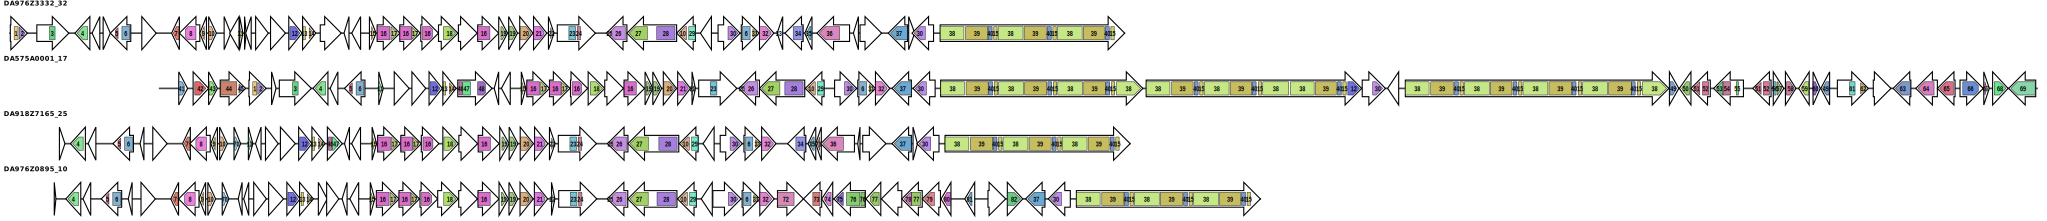

In [30]:
svg_paths = svgPaths
n_svg = len(svg_paths)
fig = sg.SVGFigure(cal_width(svgPaths,dict_gbk_gc,dict_propotion), str(100*n_svg))
figFile = []
plot = []
txt = []
for i in range(n_svg):
    label = listToString(get_key(dict_gbk_gc, os.path.split(svg_paths[i])[1].replace('svg', 'gbk')))
    figFile.append(sg.fromfile(svg_paths[i]))
    plot.append(figFile[i].getroot())
    width = float(figFile[i].get_size()[0])
    if min(list(dict_shifts.values()))<0:
        if dict_propotion[label] == 0:
            x_ref = abs(min(list(dict_shifts.values())))/dict_total[label]*width
            plot[i].moveto(x_ref, 20+100*i, scale=1)
        if dict_propotion[label] != 0:
            x = x_ref + dict_shifts[label]/dict_total[label]*width
            plot[i].moveto(x, 20+100*i, scale=1)
    if min(list(dict_shifts.values())) == 0:
        if dict_propotion[label] == 0:
            plot[i].moveto(0, 20+100*i, scale=1)
        else:
            x = dict_propotion[label]*width
            plot[i].moveto(x, 20+100*i, scale=1)
    txt.append(sg.TextElement(0, 10 + 100*i, label, size=12, weight="bold"))
fig.append(plot)
fig.append(txt)
finalSVG = os.path.join(os.path.split(svg_paths[0])[0],"fig_final.svg" )
fig.save(finalSVG)
SVG_show(filename = finalSVG)

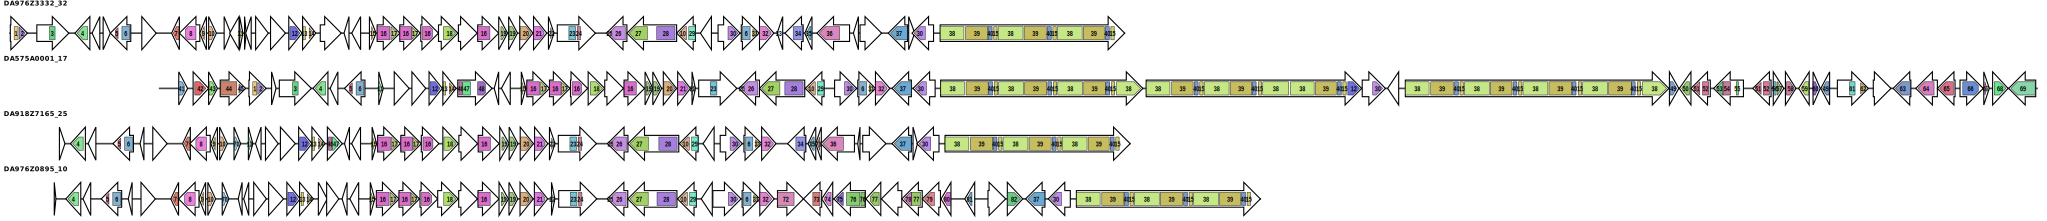

In [31]:
finalSVG = cat_svg(svg_paths, dict_gbk_gc, dict_propotion,dict_shifts,dict_total)
SVG_show(filename = finalSVG)

In [32]:
dict_gbk_gc
svgPaths 
list(dict_gbk_gc.keys())
#8079
coords_shifts = [0, 8079, 2698, 2424]
dict_shifts = dict(zip(list(dict_gbk_gc.keys()), coords_shifts))
dict_shifts
dict_total= dict(zip(list(dict_gbk_gc.keys()), [60595,102023,58164,65530]))
dict_propotion ={}
for k in dict_gbk_gc.keys():
    dict_propotion[k] = dict_shifts[k]/dict_total[k]
dict_total   
dict_propotion

{'DA976Z3332_32': 'c00058_NODE_58...region001.gbk',
 'DA575A0001_17': 'c00004_NODE_4_...region002.gbk',
 'DA918Z7165_25': 'c00045_NODE_45...region001.gbk',
 'DA976Z0895_10': 'c00026_NODE_26...region001.gbk'}

['/home/mlk442/FIND/mlk442/gcf_visulization/NRPS_263/SVG/c00058_NODE_58...region001.svg',
 '/home/mlk442/FIND/mlk442/gcf_visulization/NRPS_263/SVG/c00004_NODE_4_...region002.svg',
 '/home/mlk442/FIND/mlk442/gcf_visulization/NRPS_263/SVG/c00045_NODE_45...region001.svg',
 '/home/mlk442/FIND/mlk442/gcf_visulization/NRPS_263/SVG/c00026_NODE_26...region001.svg']

['DA976Z3332_32', 'DA575A0001_17', 'DA918Z7165_25', 'DA976Z0895_10']

{'DA976Z3332_32': 0,
 'DA575A0001_17': 8079,
 'DA918Z7165_25': 2698,
 'DA976Z0895_10': 2424}

{'DA976Z3332_32': 60595,
 'DA575A0001_17': 102023,
 'DA918Z7165_25': 58164,
 'DA976Z0895_10': 65530}

{'DA976Z3332_32': 0.0,
 'DA575A0001_17': 0.07918802622937965,
 'DA918Z7165_25': 0.04638608073722578,
 'DA976Z0895_10': 0.036990691286433695}

In [33]:
def cal_width(svgPaths, dict_gbk_gc, dict_propotion):
    widths = []
    dict_gbk2gc = dict(zip(dict_gbk_gc.values(), dict_gbk_gc.keys())) 
    for svgPath in svgPaths:
        file_folder, fname = os.path.split(svgPath)
        fname = fname.replace('svg', 'gbk')
        prop = abs(dict_propotion[dict_gbk2gc[fname]])
        wid = float(sg.fromfile(svgPath).get_size()[0])*(1+prop)
        widths.append(wid)
    max_wid = str(max(widths))
    return(max_wid)

def cat_svg(svg_paths, dict_gbk_gc, dict_propotion,dict_shifts,dict_total):
    n_svg = len(svg_paths)
    fig = sg.SVGFigure(cal_width(svg_paths,dict_gbk_gc,dict_propotion), str(100 *n_svg))
    figFile = []
    plot = []
    txt = []
    for i in range(n_svg):
        label = listToString(get_key(dict_gbk_gc, os.path.split(svg_paths[i])[1].replace('svg', 'gbk')))
        figFile.append(sg.fromfile(svg_paths[i]))
        plot.append(figFile[i].getroot())
        width = float(figFile[i].get_size()[0])
        if min(list(dict_shifts.values()))<0:
            if dict_propotion[label] == 0:
                x_ref = abs(min(list(dict_shifts.values())))/dict_total[label]*width
                plot[i].moveto(x_ref, 20+100*i, scale=1)
            if dict_propotion[label] != 0:
                x = x_ref + dict_shifts[label]/dict_total[label]*width
                plot[i].moveto(x, 20+100*i, scale=1)
        if min(list(dict_shifts.values())) == 0:
            if dict_propotion[label] == 0:
                plot[i].moveto(0, 20+100*i, scale=1)
            else:
                x = dict_propotion[label]*width
                plot[i].moveto(x, 20+100*i, scale=1)
        txt.append(sg.TextElement(0, 10 + 100*i, label, size=12, weight="bold"))
    fig.append(plot)
    fig.append(txt)
    finalSVG = os.path.join(os.path.split(svg_paths[0])[0],"fig_final.svg" )
    fig.save(finalSVG)
    return (finalSVG)    
    

In [34]:
widths
dict_total

NameError: name 'widths' is not defined

In [35]:
fig = sg.SVGFigure("60cm", '4cm')
figFile = sg.fromfile('/home/mlk442/FIND/mlk442/gcf_visulization/NRPS_263/SVG/c00026_NODE_26...region001.svg')
plot = figFile.getroot()
plot.rotate(180, 1100, 40)
fig.append(plot)
fig.save("fig_rotate.svg")
SVG_show(filename = "/home/mlk442/FIND/mlk442/gcf_visulization/fig_rotate.svg")


In [36]:
record1 = SeqIO.read("/home/mlk442/FIND/mlk442/gcf_visulization/NRPS_263/origGBK/c00026_NODE_26...region001.gbk", "genbank")
record2 = SeqIO.read("/home/mlk442/FIND/mlk442/gcf_visulization/NRPS_263/GBKfile/c00026_NODE_26...region001.gbk", "genbank")

In [37]:
for feature1 in record1.features:
    for feature2 in record2.features:
        if (feature1.type == "CDS") and (feature2.type == 'CDS') and (feature1.location == feature2.location):
            if "gene" in feature2.qualifiers.keys():
                feature1.qualifiers['gene'] = feature2.qualifiers['gene']
            if "product" in feature2.qualifiers.keys():
                feature1.qualifiers['product'] = feature2.qualifiers['product']                
        
with open("/home/mlk442/FIND/mlk442/gcf_visulization/NRPS_263/origGBK/c00026_NODE_26...region001.gbk", "w") as handle:
    SeqIO.write(record1, handle, "genbank")       
    

1

In [38]:
for feature1 in record1.features:
    if "gene" in feature1.qualifiers.keys():
        print (feature1.qualifiers['gene'])

['luxA']
['moaA']
['pqqE']
['novN']
['spoT']
['gltX']
['drrB']
['drrA']
['hpgT']
['tyrC']
['mbtH']
['nsaD']
['fabG']
['fabZ_2']
['fabF_1']
['menH']
['fabF_2']
['fabF_3']
['acpP']
['afsR_1']
['afsR_2']
['pikAV']
['yjbR']
['cadI']
['arsR1']
['acr3']
['sugC']
['rfbF']


In [39]:
feature1.location

FeatureLocation(ExactPosition(65424), ExactPosition(65529), strand=-1)

In [40]:
%pwd

'/scale03/fs0/gpfs0/research/dsi-find/mlk442/gcf_visulization'

In [41]:
fig = svgPaths('/home/mlk442/FIND/mlk442/gcf_visulization/NRPS_263/SVG/c00026_NODE_26...region001.svg')

TypeError: 'list' object is not callable

In [42]:
fig = sg.SVGFigure("100cm", ''.join([str(3*2),"cm"]))
figFile= sg.fromfile(finalSVG)
plot = figFile.getroot()
plot.moveto(0, 0, scale=0.6)
fig.append(plot)
fig.save(finalSVG)
SVG_show(filename = finalSVG)

In [43]:
# For future purpose, generate files for all gcfs
dict_all_gc={}
for gcfName in filter_dict_gcf.keys():
    print(gcfName)
    processed_gbk, dict_gbk_gc  = run_visual(gcfName, filter_dict_gcf, visualDir)
    dict_all_gc.update(dict_gbk_gc)

NRPS_15
 output folder already exists
 input folder already exists
 Cache folder already exists
 BGCfastas folder already exists
 Domtable folder already exists
 Domains folder already exists
 pfs folder already exists
 pfd folder already exists
 SVG folder already exists
 Logs folder already exists


KeyboardInterrupt: 

In [ ]:
#for future interactive visualization purpose
from ipywidgets import interact
@interact(gf = filter_dict_gcf.keys())
def bgc_table(gf = "NRPS_26"):
    gcs = filter_dict_gcf[gf]
    images = []
    for gc in gcs:
        print(gc)
        svg =  dict_all_gc[gc].split("gbk")[0] +"svg"
        svgPath = os.path.join(visualDir, gf, "SVG", svg)     
        SVG_show(filename = svgPath)
    

In [ ]:
pfam_text

In [ ]:
11 in list(set([1,2,2,5,3,3,7,8,9,9,2]))

In [ ]:
pfTable 

In [44]:
filter_dict_gcf

{'NRPS_15': ['DA007R0002_14',
  'DA976Z0987_11',
  'DA011Q0003_26',
  'DA976Z3334_1',
  'DA011H0003_25',
  'DA008K0001_33',
  'DA976Z0897_34',
  'DA976Z0883_9',
  'DA976Z0955_8',
  'DA007N0001_6',
  'DA011G0002_31',
  'DA976Z0983_13',
  'DA977Z0126_24',
  'DA004A0004_24',
  'DA017B0001_29',
  'DA011F0003_36',
  'DA011K0001_35',
  'DA008E0001_31',
  'DA017B0002_28',
  'DA976Z0994_32',
  'DA918Z7170_26',
  'DA936Z0011_11',
  'DA011D0002_13',
  'DA976Z0857_16',
  'DA977Z0282_4',
  'DA977Z0281_16',
  'DA976Z0893_10',
  'DA976Z0936_28',
  'DA936Z0011_12',
  'DA976Z1425_16',
  'DA977Z1029_7'],
 'NRPS_263': ['DA976Z3332_32',
  'DA575A0001_17',
  'DA918Z7165_25',
  'DA976Z0895_10'],
 'NRPS_265': ['DA976Z0996_7'],
 'NRPS_8': ['DA976Z3334_14',
  'DA976Z0897_11',
  'DA008E0001_2',
  'DA976Z0883_13',
  'DA976Z0893_12',
  'DA011K0001_2',
  'DA017B0002_2',
  'DA017B0001_2',
  'DA976Z0994_3',
  'DA007R0002_8',
  'DA004A0004_1',
  'DA011H0003_1',
  'DA976Z0955_5',
  'DA976Z0936_15',
  'DA007N0001_10',

In [46]:
len(filter_dict_gcf.keys())

4353